In [2]:
import math
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

# read data

In [3]:
words = open('../data/names.txt', 'r').read().splitlines()

In [4]:
len(words)

32033

In [5]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [6]:
chars = sorted(list(set(''.join(words))))

# util

In [7]:
itos = {}
itos[0] = '.'
itos |= {i+1: s for i, s in enumerate(chars)}

In [8]:
stoi = {s: i for i, s in itos.items()}

In [9]:
vocab_size = len(stoi)
vocab_size

27

# Build a neural language model

## prepare data

In [10]:
BLOCK_SIZE = 3
def build_dataset(data):
    X, Y = [], []
    for w in data[:]:
        # print(w)
        context = [0] * BLOCK_SIZE
        for ch in w + '.':
            ix = stoi[ch]
            # print(''.join([itos[i] for i in context]), '--->', itos[ix])
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]        

    X = torch.tensor(X)
    Y = torch.tensor(Y)        
    print(X.shape, Y.shape)
    return X, Y

In [11]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
         
Xtr, Ytr = build_dataset(words[:n1])
Xdv, Ydv = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])                               

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Train a neural language model

In [30]:
EMBD_DIM = 10
HIDDEN_DIM = 200

In [120]:
C = torch.randn(len(itos), EMBD_DIM)
w1 = torch.randn(EMBD_DIM*BLOCK_SIZE, HIDDEN_DIM) / (EMBD_DIM*BLOCK_SIZE)**0.5
b1 = torch.randn(HIDDEN_DIM) *0.01
w2 = torch.randn(HIDDEN_DIM, vocab_size) * 0.02
b2 = torch.randn(vocab_size) * 0.01

bngain = torch.ones(1, HIDDEN_DIM)
bnbias = torch.zeros(1, HIDDEN_DIM)

bnmean_running = torch.zeros(1, HIDDEN_DIM)
bnstd_running = torch.ones(1, HIDDEN_DIM)

parameters = [C, w1, b1, w2, b2, bngain, bnbias]

In [95]:
sum(p.nelement() for p in parameters)

12297

In [96]:
for p in parameters:
    p.requires_grad = True

In [97]:
loglossi = []
lossi = []

In [98]:
# STEPS = 800_000
STEPS = 200_000
# STEPS = 20_000
for i in tqdm(range(STEPS)):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward
    emb = C[Xb] # (32, 3, 2)
    hpreact = emb.view(emb.shape[0], -1) @ w1 + b1
    bnmeani = hpreact.mean(0,keepdim=True)
    bnstdi = hpreact.std(0,keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    
    h = (hpreact).tanh() # (32, 100)
    logits = h @ w2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < STEPS//2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # tracking
    loglossi.append(loss.log10().item())
    lossi.append(loss.item())
    
    if i > 1000:
        # break
        pass

100%|████████████████████████████████████████████████████████| 200000/200000 [02:22<00:00, 1405.25it/s]


# check bngain and bnbias

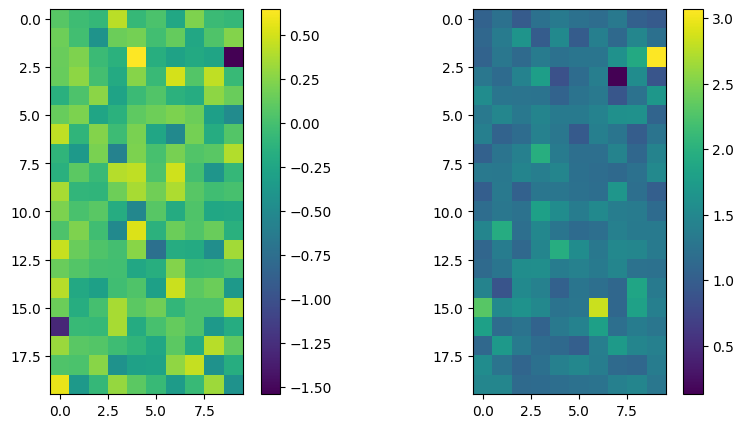

In [138]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(bnbias.view(20,-1).data)
plt.colorbar()
plt.subplot(122)
plt.imshow(bngain.view(20,-1).data)
plt.colorbar()

In [139]:
hpreact.view(-1).mean()

tensor(0.1088)

In [102]:
hpreact.view(-1).std()

tensor(2.1954)

# plot loss

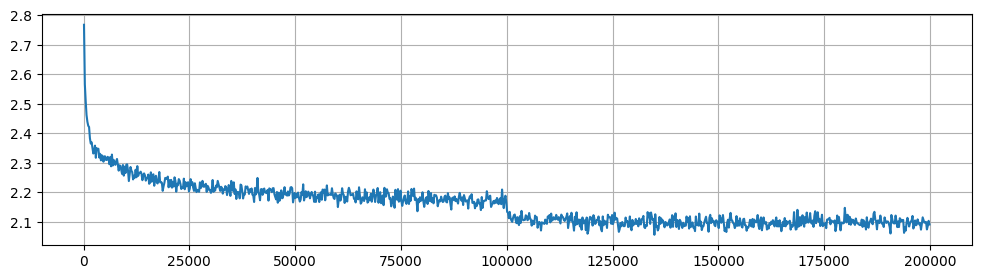

In [148]:
group_size = 200
plt.figure(figsize=(12,3))
plt.plot(
    torch.arange(len(lossi)).view(-1, group_size).float().mean(1),
    torch.tensor(lossi).view(-1, group_size).mean(1)
)
plt.grid()
plt.show()

In [146]:
lossi[-5:]

[2.2177562713623047,
 1.7852283716201782,
 1.8629157543182373,
 2.0511138439178467,
 1.9359846115112305]

## compute loss on train/dev/test

In [149]:
# calibrate the batch norm at the end of the training

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ w1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [152]:
@torch.no_grad()
def eval_dataset(X, Y):
    emb = C[X] # (32, 3, 2)
    hpreact = emb.view(emb.shape[0], -1) @ w1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = (hpreact).tanh() # (32, 100)
    logits = h @ w2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

In [153]:
eval_dataset(Xtr, Ytr)
eval_dataset(Xdv, Ydv)
# eval_dataset(Xte, Yte)

2.0640869140625
2.1077370643615723


In [137]:
eval_dataset(Xtr, Ytr)
eval_dataset(Xdv, Ydv)
# eval_dataset(Xte, Yte)

2.0643064975738525
2.107557535171509


In [117]:
bnmean.shape, bnstd.shape

(torch.Size([1, 200]), torch.Size([1, 200]))

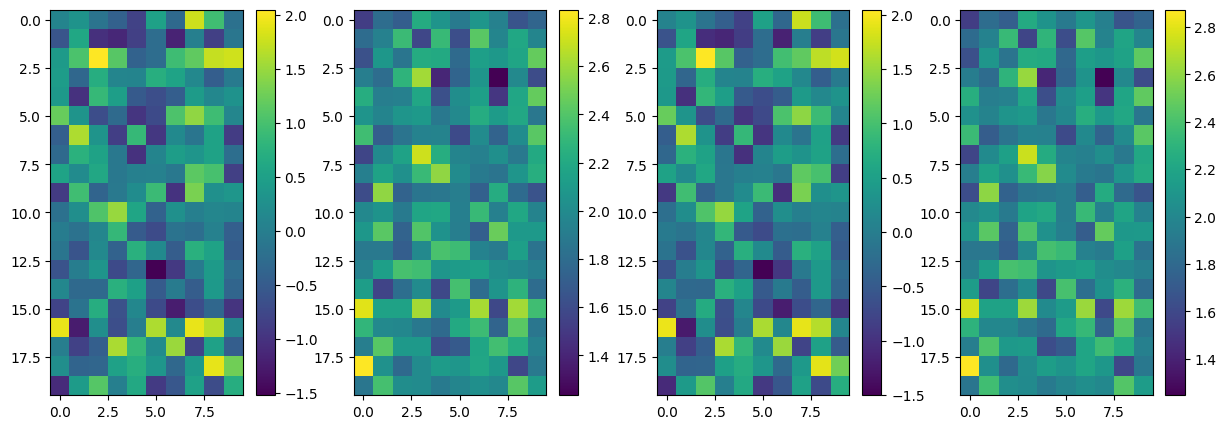

In [134]:
plt.figure(figsize=(15,5))
plt.subplot(141)
plt.imshow(bnmean_running.view(20,-1).data)
plt.colorbar()
plt.subplot(142)
plt.imshow(bnstd_running.view(20,-1).data)
plt.colorbar()
plt.subplot(143)
plt.imshow(bnmean.view(20,-1).data)
plt.colorbar()
plt.subplot(144)
plt.imshow(bnstd.view(20,-1).data)
plt.colorbar()

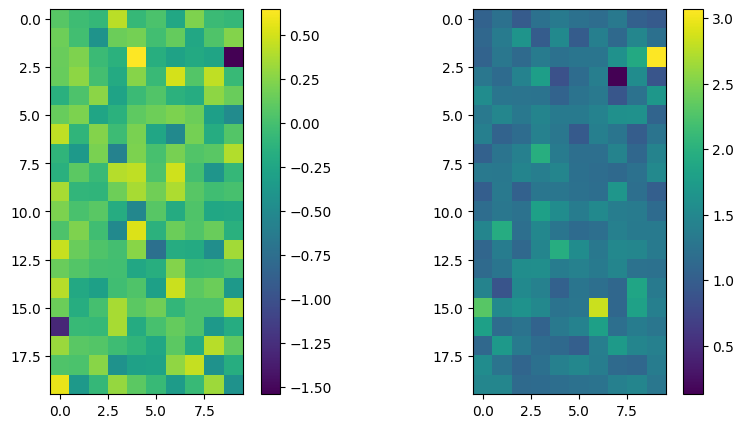

In [135]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(bnbias.view(20,-1).data)
plt.colorbar()
plt.subplot(122)
plt.imshow(bngain.view(20,-1).data)
plt.colorbar()